# FTV Digital Phantom
This notebook creates a 4D DCEMRI synthetic image to replicate FTV calculations for different PE and SER values. The signal is derived from a baseline T1 value and assuming SPGR acquisition. The voxels in the image represent different (known) PE and SER values so FTV calculation is easily predicted from the data. Each region is enclosed in a non-varying T1 value, so it can be easily delineated with the Roi box defined in Slicer 3D 

## [Import relevant modules](#python-modules)

In [13]:
import os
import cv2
import json
import datetime
import numpy as np
import pandas as pd
import pydicom as pyd
import nibabel as nib
import matplotlib.pyplot as plt
from lmfit import minimize, Parameters

# If the background colour of the plots is the same as the VS theme, check the option jupyter.themeMatplotlibPlots, 
# as indicated at https://stackoverflow.com/questions/75154449/vscode-setup-question-python-plot-background-color
# --> In macOS, go to Code -> Settings -> Settings -> Users -> jupyter:themeMatplotlibPlots

# Additional PyDicom tools
from pydicom.dataset import Dataset, FileMetaDataset
from pydicom.sequence import Sequence


## [Auxiliar Functions](#auxiliar-functions)

### Default Phantom data

In [14]:
def replace_default_value(meta_data_struct, updated_structure, debug=False):
    
    for key, val in updated_structure.items():
        if not (key in meta_data_struct) and debug:
            print(f"Attribute {key} will be added to the data structure with the value:\n {updated_structure[key]}")
        meta_data_struct[key] = updated_structure[key]
            
    
    return meta_data_struct
            
def create_dicom_header(user_info):
    """
    Args:
        user_info (dictionary): dictionary containing the DICOM parameters for each file to be created. They can be any DICOM attribute as long as it is consistent with the dicom definition
        
    """
    # -*- coding: utf-8 -*-
    # Coded version of DICOM file 'sample_DICOM_EilB-preTreatment.dcm'
    # Produced by pydicom codify utility script

    # File meta info default data elements
    file_meta = FileMetaDataset()
    file_meta.FileMetaInformationGroupLength = 190
    file_meta.FileMetaInformationVersion = b'\x00\x01'
    file_meta.MediaStorageSOPClassUID = '1.2.840.10008.5.1.4.1.1.4'        
    file_meta.MediaStorageSOPInstanceUID = '2.16.840.1.114362.1.12081536.24564705482.663432844.303.199'
    file_meta.TransferSyntaxUID = '1.2.840.10008.1.2.1'
    file_meta.ImplementationClassUID = '2.16.840.1.114362.1'
    file_meta.ImplementationVersionName = 'MIM716LB1000'
    
    # if user_info contains some of them, they will be replaced in here:
    file_meta = replace_default_value(file_meta, user_info['file_metadata'])    

    # Main data elements - default values
    ds = Dataset()
    ds.SpecificCharacterSet = 'ISO_IR 100'
    ds.ImageType = ['ORIGINAL', 'PRIMARY', 'M_FFE', 'M', 'FFE']
    ds.InstanceCreationDate = '20230621'
    ds.InstanceCreationTime = '145825.067'
    ds.InstanceCreatorUID = '1.3.46.670589.11.89.5'
    ds.SOPClassUID = '1.2.840.10008.5.1.4.1.1.4'
    ds.SOPInstanceUID = '2.16.840.1.114362.1.12081536.24564705482.663432844.303.199'
    ds.StudyDate = '20230621'
    ds.SeriesDate = '20230621'
    ds.AcquisitionDate = '20230621'
    ds.ContentDate = '20230621'
    ds.StudyTime = '101805'
    ds.SeriesTime = '105040.07000'
    ds.AcquisitionTime = '105057.46'
    ds.ContentTime = '105057.46'
    ds.AccessionNumber = ''
    ds.Modality = 'MR'
    ds.ConversionType = ''
    ds.Manufacturer = 'Philips'
    ds.InstitutionName = ''
    ds.ReferringPhysicianName = ''
    ds.CodeValue = ''
    ds.CodingSchemeDesignator = ''
    ds.CodeMeaning = ''
    ds.StudyDescription = 'MRI Trial Imaging with Contrast'

    # Procedure Code Sequence
    procedure_code_sequence = Sequence()
    ds.ProcedureCodeSequence = procedure_code_sequence

    # Procedure Code Sequence: Procedure Code 1
    procedure_code1 = Dataset()
    procedure_code_sequence.append(procedure_code1)
    procedure_code1.CodeValue = 'UNDEFINED'
    procedure_code1.CodingSchemeDesignator = 'UNDEFINED'
    procedure_code1.CodingSchemeVersion = 'UNDEFINED'
    procedure_code1.CodeMeaning = 'UNDEFINED'
    procedure_code1.ContextGroupExtensionFlag = 'N'

    ds.SeriesDescription = 'Dyn eTHRIVE'
    ds.ManufacturerModelName = 'Ingenia Ambition X'


    ds.PatientName = 'EilB Pre TREATMENT'
    ds.PatientID = 'ANON98269'
    ds.PatientBirthDate = ''
    ds.PatientSex = 'F'
    ds.PatientAge = '081Y'
    ds.PatientWeight = '48.0'
    ds.MedicalAlerts = ''
    ds.Allergies = ''
    ds.EthnicGroup = ''
    ds.PregnancyStatus = 1
    ds.PatientIdentityRemoved = 'YES'
    ds.DeidentificationMethod = 'Limited Data Set: MIM.7.1.6.LB10-00'
    ds.ContrastBolusAgent = ''
    ds.BodyPartExamined = 'PHANTOM'
    ds.ScanningSequence = 'GR'
    ds.SequenceVariant = 'SP'
    ds.ScanOptions = 'FS'
    ds.MRAcquisitionType = '3D'
    ds.SliceThickness = '3.0'
    ds.RepetitionTime = '5.19999980926513'
    ds.EchoTime = '2.501'
    ds.NumberOfAverages = '1.0'
    ds.ImagingFrequency = '63.882648'
    ds.ImagedNucleus = '1H'
    ds.EchoNumbers = '1'
    ds.MagneticFieldStrength = '1.5'
    ds.SpacingBetweenSlices = '1.5'
    ds.NumberOfPhaseEncodingSteps = '359'
    ds.EchoTrainLength = '42'
    ds.PercentSampling = '78.5398178100586'
    ds.PercentPhaseFieldOfView = '128.155343191964'
    ds.PixelBandwidth = '433.0'
    ds.DeviceSerialNumber = '0'
    ds.SecondaryCaptureDeviceID = ''
    ds.SecondaryCaptureDeviceManufacturer = ''
    ds.SecondaryCaptureDeviceManufacturerModelName = ''
    ds.SecondaryCaptureDeviceSoftwareVersions = ''
    ds.SoftwareVersions = ['5.7.1', '5.7.1.3']
    ds.VideoImageFormatAcquired = ''
    ds.DigitalImageFormatAcquired = ''
    ds.ProtocolName = 'Dyn eTHRIVE'
    ds.TriggerTime = '0.0'
    ds.LowRRValue = '0'
    ds.HighRRValue = '0'
    ds.IntervalsAcquired = '0'
    ds.IntervalsRejected = '0'
    ds.HeartRate = '0'
    ds.ReconstructionDiameter = '359.0'
    ds.ReceiveCoilName = 'SENSE_BREAST_7M_'
    ds.AcquisitionMatrix = [0, 359, 359, 0]
    ds.InPlanePhaseEncodingDirection = 'ROW'
    ds.FlipAngle = '10.0'
    ds.SAR = '0.22448302805423'
    ds.dBdt = '56.1810722351074'
    ds.B1rms = 1.089730978012085
    ds.PatientPosition = 'FFP'
    ds.AcquisitionDuration = 64.85399627685547
    ds.DiffusionBValue = 0.0
    ds.DiffusionGradientOrientation = [0.0, 0.0, 0.0]
    ds.StudyInstanceUID = '2.16.840.1.114362.1.12081536.24564705482.663432844.273.172'
    ds.SeriesInstanceUID = '2.16.840.1.114362.1.12081536.24564705482.663432844.273.173'
    ds.StudyID = 'ANON18218'
    ds.SeriesNumber = '501'
    ds.AcquisitionNumber = '5'
    ds.InstanceNumber = '493'
    ds.ImagePositionPatient = [-168.43985679745, -143.33447197079, 57.8474731445313]
    ds.ImageOrientationPatient = [1, 0, 0, 0, 1, 0]
    ds.FrameOfReferenceUID = '2.16.840.1.114362.1.12081536.24564705482.663432844.273.174'
    ds.Laterality = ''
    ds.TemporalPositionIdentifier = '1'
    ds.NumberOfTemporalPositions = '6'
    ds.PositionReferenceIndicator = ''
    ds.SliceLocation = '-57.847473144531'
    ds.SamplesPerPixel = 1
    ds.PhotometricInterpretation = 'MONOCHROME2'
    ds.Rows = 528
    ds.Columns = 528
    ds.PixelSpacing = [0.67961162328720, 0.67961162328720]
    ds.BitsAllocated = 16
    ds.BitsStored = 12
    ds.HighBit = 11
    ds.PixelRepresentation = 0
    ds.WindowCenter = '1214.0'
    ds.WindowWidth = '2110.0'
    ds.RescaleIntercept = '0.0'
    ds.RescaleSlope = '11.0383394383394'
    ds.RescaleType = 'normalized'
    ds.RequestedProcedureDescription = 'MRI Trial Imaging with Contrast'
    ds.RequestedContrastAgent = ''
    ds.StudyComments = ''
    ds.SpecialNeeds = ''
    ds.PatientState = ''
    ds.ScheduledPerformingPhysicianName = ''
    ds.PerformedStationAETitle = 'MRSIM'
    ds.PerformedStationName = ''
    ds.PerformedLocation = ''
    ds.PerformedProcedureStepEndDate = '20230621'
    ds.PerformedProcedureStepEndTime = '101805'
    ds.PerformedProcedureStepStatus = ''
    ds.PerformedProcedureTypeDescription = ''

    ds.PixelData = ''# XXX Array of 557568 bytes excluded

    # if user_info contains some of them, they will be replaced in here:
    ds = replace_default_value(ds, user_info['dataset_metadata'])

    ds.file_meta = file_meta
    ds.is_implicit_VR = False
    ds.is_little_endian = True
    
    return ds


### [T1W sequences - SPGR & IR](#t1w-functions)

In [15]:
def M0(k, rho):
    
    return k*rho

def relaxationTerm(acquisitionTpar, relaxationTime):

    expTacqRelT = np.exp(- acquisitionTpar / (relaxationTime + 1e-9))
    expTacqRelT *= (relaxationTime > 0.0)
    return expTacqRelT

def E1(TR, T1):
    
    return relaxationTerm(TR,T1)

def E2(TE, T2star):
    
    return relaxationTerm(TE,T2star)


In [16]:
def spgr_signal(s0, t1, tr, flip_angle, te, t2star):
    
    fa_radians = np.deg2rad(flip_angle)
    t2contrib = E2(TE=te, T2star=t2star)
    t1contrib = E1(TR=tr, T1=t1)
    
    num = (1 - t1contrib) 
    den = (1-np.cos(fa_radians)*t1contrib)
    scaling_factor = s0*np.sin(fa_radians)
    s = scaling_factor * t2contrib * num / den

    return s

# Define cost functions to estimate T1 with SPGR and IR
def fit_SPGR_t1(params, flip_angle, values):
    s0 = params['s0'].value
    t1 = params['t1'].value
    tr = params['tr'].value
    te = params['te'].value
    t2star = params['t2star'].value

    s = spgr_signal(s0, t1, tr, flip_angle, te, t2star)
    return (np.fabs(s) - np.fabs(values))

# Define the optimisation method
def do_spgr_fit(ydata, fa, tr, te, t2star, initial_s0=1.0, initial_t1=1000.0):
    params = Parameters()
    params.add('s0', value=initial_s0, vary=True)
    params.add('t1', value=initial_t1, vary=True, min=0.0, max=10000.0)
    params.add('tr', value=tr, vary=False)
    params.add('te', value=te, vary=False)
    params.add('t2star', value=t2star, vary=False)
    
    result = minimize(fit_SPGR_t1, params, args=(fa, ydata))

    return result    


In [17]:
def ir_signal(s0, t1, ti, tr, nte=0, f=1.0, k2=-1.0, C=1.0):
    
    return s0*(1-2 * f * np.exp(-(ti/t1)) - C * k2 * np.exp(-(tr-nte)/t1))


# Define fitting functions to estimate T1 with SPGR and IR
def fit_IR_t1(params, inv_times, values):
    s0 = params['s0'].value
    t1 = params['t1'].value
    tr = params['tr'].value
    nte = params['nte'].value
    c = params['c'].value
    f = params['f'].value
    f2 = params['f2'].value

    s = ir_signal(s0, t1, inv_times, tr, nte, f, f2, c)
    return (np.fabs(s) - np.fabs(values))

def do_ir_fit(ydata, tinv, tr, initial_s0=1.0, initial_t1=1000.0, phi=1.0, k2=-1.0, nte=0):
    
    params = Parameters()
    params.add('s0', value=initial_s0, vary=True)
    params.add('t1', value=initial_t1, vary=True, min=0.0, max=10000.0)
    params.add('f', value=phi, vary=True, min=0.0, max = 2.0)
    params.add('tr', value=tr, vary=False)
    params.add('nte', value=nte, vary=False)
    params.add('c', value=1.0, vary=False)
    params.add('f2', value=k2, vary=False)

    result = minimize(fit_IR_t1, params, args=(tinv, ydata))

    return result
        

### Semi-quant parameters

In [18]:
def s2_ser(st1, ser_value, st0):
    
    st2 = (st1 + (ser_value - 1.0)*st0) / (ser_value + 1e-6)
   
    return st2

def s1_pe(st0, pe_value):
    # if np.isscalar(pe_value):
    st1 = st0*(0.01*pe_value+1.0)
    
    return st1


### Drawing utilities

In [19]:
def get_coordinates_from_size(shape_size, shape_centre, shape='rect'):
    
    if shape == 'rect':
        ab = [int(centre - size * 0.5 ) for centre, size in zip(shape_centre, shape_size)]
        cd = [int(centre + size * 0.5 ) for centre, size in zip(shape_centre, shape_size)]
    elif shape == 'circ':
        ab = [int(coord) for coord in shape_centre]
        cd = int(shape_size/2) # radius must be integer
        
    return ab, cd


## Spoiled Gradient Echo signal equation

The Spoiled Gradient Echo (SPGR) sequence is one of the most widely used MRI T1W sequences. Because it is a fast sequence that offers flexibility to favour T1 or T2 weighted, it is commonly used in dynamic studies. 
The variable flip angle (VFA) method to measure T1 relaxation, is derived from the signal equation of the SPGR sequence. There is a lot of literature available about this method, so in this notebook I'll cover the major and earlier papers providing the mathematical framework for this method.
The signal equation of the SPGR is a function of multiple parameters [Fram et al., MRI 5(3):201-8; 1987](https://pubmed.ncbi.nlm.nih.gov/3626789/):
\begin{equation} %\label{spgr}
S(\rho, \alpha, T_E, T_R, T_1, T_2^{*}) = k\rho\sin{\alpha}\frac{(1 - e^{-T_R/T_1})}{(1 - (\cos{\alpha})e^{-T_R/T_1})}e^{-T_E/T_2^{*}}
\end{equation}

where $\alpha/T_E/T_R$ are acquisition-controlled parameters: Flip Angle (degrees), Echo Time (ms) and Repetition Time (ms), respectively. $\rho/T_1/T_2$ are intrinsic parameters of the sample: spin density, longitudinal and transverse relaxation constants, respectively. $k$ is an arbitrary constant representing the effect of the $B_1$ inhomogeneity of the RF transmission coil.

Equation [1] (\ref{spgr}) can be rewritten more concisely by considering the following:

<!-- \begin{itemize} -->
<!-- \item  -->
* The arbitrary constant $k$ and the spin density $\rho$ can be grouped into a single parameter $M_0$.
<!-- \item  -->
* The effect of the intrinsic relaxation times $T_1$ and $T_2$, and the acquisition parameters $T_1$ and $T_2$ are grouped in the function forms $E_1(T_1, T_R) = \exp(-T_R/T_1) $ and $E_2(T_2^{*}, T_E) = \exp(-T_E/T_2^{*})$, respectively:
<!-- \end{itemize} -->

\begin{equation}
S(M_0, \alpha, T_E, T_R, T_1, T_2^{*}) = M_0\sin\alpha\frac{1 - E_1(T_1,T_R)}{1 - (\cos\alpha)E_1(T_1,T_R)}E_2(T_2^{*}, T_E)
\end{equation}

Generalising this equation for a time varying $T_1$, we get it formulated as:

\begin{equation}
S(M_0, \alpha, T_E, T_R, T_1(t), T_2^{*}) = M_0\sin\alpha\frac{1 - E_1(T_1(t),T_R)}{1 - (\cos\alpha)E_1(T_1(t),T_R)}E_2(T_2^{*}, T_E)
\end{equation}


## Average T1 values of some tissues at 1.5T (see Appendix 2)

In [20]:
tissue_pars = {'breast_fat': {'T1': 334,
                              'T2': 53,
                              'M0': 1000.0,
                              'colour': 'gray',
                              },
               'breast_glandular': {'T1': 1201,
                                    'T2': 58,
                                    'M0': 5000.0,
                                    'colour': 'magenta',
                                    },
               'breast_malignancy': {'T1': 876,
                                     'T2': 75,
                                     'M0': 5000.0,
                                     'colour': 'red',
                                     },
               'liver': {'T1': 500,
                         'T2': 40,
                         'M0': 1000,
                         'colour': 'brown'
                   },
               'arterial_blood': {'T1': 1434,
                                  'T2': 254,
                                  'M0': 7000.0,
                                  'colour': 'orange',                              
                                  },
               'major_muscle': {'T1': 900,
                                'T2': 50,
                                'M0': 3000.0,
                                'colour': 'blue',
                                },
               'water_csf': {'T1': 4000,
                             'T2': 2000,
                             'M0': 10000.0,
                             'colour': 'green',
                             },
               'ice': {'T1': 5000,
                       'T2': 0.001,
                       'M0': 1000,
                       'colour': 'cyan'}
               }


## MRI acquisition and Image parameters
Image Parameters:
|Parameter | Values |  Units |
| :----:   | :----: | :----: | 
|Image Dimensions | $[528 \times 528 \times 120]$ | pixels |
|Image Resolutions | $[0.68 \times 0.68 \times 1.5]$ | mm/pixels |
| TR | 5.2 | ms|
| TE | 2.5 | ms|
| FA | 10  | degree|

Tissues Relaxation Times:
| Tissue | $T_1$ [ms] | $T_2$ [ms] |
| :----: |    :----:  |   :----:   |
|Breast Fat     |  334  | 53 |
|Glandular Breast Tissue | 1201 | 58 |
|Breast Malignant Tissue | 876  | 75 |
|Blood          |  1434  | 254 |
|Major Muscle   |   900  |  50 |
| Water/CSF     |  4000  |  2000 |



In [21]:
image_dim  = [528, 528, 120] # pixels ny(row), nx(col), nz(depth)
image_res  = [0.68, 0.68, 1.5] # mm/pix
image_size = [imdim*imgres for imdim, imgres in zip(image_dim, image_res)]

print(f"Image size is [{' x '.join(str(dim) for dim in image_size)}]mm")

# These are relevant for when importing to DICOM files:
image_pars = {'dimensions': image_dim,
              'resolution': image_res,
              'image_size': image_size,
              'TR': 5.2,
              'ETL': 42,
              'TE': 2.5,
              'FA': 10,
              'pFOV': 130,
              'pPE': 80, 
              'pSL': 2.0, # Slice Overlap factor (i.e. )
              'nBits': 16
              }

phTime = image_pars['ETL'] * image_pars['TR']
imgTime = phTime * ( image_dim[1] * image_pars['pPE'] / 100 ) * ( ( 200 - image_pars['pFOV'] ) / 100 )
volTime = imgTime * image_dim[-1] / image_pars['pSL']
Tacq = volTime / ( 1000 * 60 ) # Acquisition time of 1 volume in seconds
image_pars['Tacq'] = Tacq
print(f'Tacq: {Tacq}s')

T1map = np.zeros((image_dim))
T2map = np.zeros((image_dim))
M0map = np.zeros((image_dim))


Image size is [359.04 x 359.04 x 180.0]mm
Tacq: 64.576512s


# MRI Signal from T1 baseline - Simulations
Let's create the T1W baseline (i.e. pre-contrast) image.

A high T1 ensures the boundaries will look brighter so will help to delineate each region

Each region gets defined as a rectangle with corners (xa, yb) and (xc, yd) (Numpy/OpenCV (col, row) indexing and upper-left origin convention):
```
 _____ x                                
 |                                      
 |    (xa,yb) *---------------o         
 |            |               |         
y|            |               |         
              |               |         
              |               |         
              o---------------* (xc, yd)
```

**IMPORTANT** 
The drawing above uses the numpy convention, that the index starts at the lower left corner. In OpenCV, the origin is in the upper left corner

In [22]:
baseline_images = {'T1': np.zeros(image_dim[:-1]),
                   'T2star': np.zeros(image_dim[:-1]),
                   'M0': np.zeros(image_dim[:-1]),
                   'St': np.zeros(image_dim[:-1]),
                   'PE': np.zeros(image_dim[:-1]),
                   'SER': np.zeros(image_dim[:-1]),
}

# Define the sample boundaries
boundary_pars = {'t10': tissue_pars['ice']['T1'], # A high T1 ensures the boundaries will look brighter
                 't2s0': tissue_pars['ice']['T2'],  # A very low T2star ensures the contribution of the T2-decay is negligible
                 'M0':   tissue_pars['ice']['M0'],  # A reference M0
}

boundary_width = 10 # pixels
# Let's position the outer rectangle centred in the image (OpenCV convention: [x(col), y(row), z])
# Because this is symmetric, doesn't matter which is x and y, but later, it'll be obvious...
boundary_size = [3*dim/4 for dim in image_dim[:-1]] # size is 75% of the image size
boundary_centre = [dim/2 for dim in image_dim[:-1]]
# [centre, radius] = get_coordinates_from_size(boundary_size[0], boundary_coord, shape='circ')
# cv2.circle(baseline_image_St, centre, radius, St0, boundary_width)

# Add more tissues into the sample
organs_width = 3 # pixels

liver_size = [3*boundary_size[0]/4, 1*boundary_size[1]/2] # [x(col), y(row)]
liver_centre = [boundary_centre[0], 5*boundary_centre[1]/4] # [x(col), y(row)]

heart_size = [1*boundary_size[0]/5, 1*boundary_size[1]/5] # [x(col), y(row)]
heart_centre = [liver_centre[0], liver_centre[1] - liver_size[1]/2 + heart_size[1]/2 ] # [x(col), y(row)]

# Lets subdivide the breast for different PE values (and later on, different SER values)
lbreast_size = [1*boundary_size[0]/5, 1*boundary_size[1]/4] # [x(col), y(row)]
lbreast_centre = [2*liver_centre[0]/3, liver_centre[1] - liver_size[1]/2 - lbreast_size[1]/2 ] # [x(col), y(row)]

lbreast_quad_size = [lbreast_size[0], lbreast_size[1]/2]
lbreast_upper_centre = [lbreast_centre[0], lbreast_centre[1] - (lbreast_quad_size[1]/2)] # [x(col), y(row)]
lbreast_lower_centre = [lbreast_centre[0], lbreast_centre[1] + (lbreast_quad_size[1]/2)] # [x(col), y(row)]

lbreast_lat_size = [lbreast_size[0]/2, lbreast_size[1]]
lbreast_left_centre = [lbreast_centre[0] - (lbreast_lat_size[0]/2), lbreast_centre[1]]
lbreast_right_centre = [lbreast_centre[0] + (lbreast_lat_size[0]/2), lbreast_centre[1]]


rbreast_size = lbreast_size
rbreast_centre = [4*liver_centre[0]/3, lbreast_centre[1]] # [x(col), y(row)]

rbreast_quad_size = [rbreast_size[0], rbreast_size[1]/2]
rbreast_upper_centre = [rbreast_centre[0], rbreast_centre[1] - (rbreast_quad_size[1]/2)] # [x(col), y(row)]
rbreast_lower_centre = [rbreast_centre[0], rbreast_centre[1] + (rbreast_quad_size[1]/2)] # [x(col), y(row)]

rbreast_lat_size = [rbreast_size[0]/2, rbreast_size[1]]
rbreast_left_centre = [rbreast_centre[0] - (rbreast_lat_size[0]/2), rbreast_centre[1]]
rbreast_right_centre = [rbreast_centre[0] + (rbreast_lat_size[0]/2), rbreast_centre[1]]

sample_tissues = {'outer': {'coordinates': get_coordinates_from_size(boundary_size, boundary_centre),
                            'boundary_mripars': {'t1': boundary_pars['t10'],
                                                 't2star': boundary_pars['t2s0'],
                                                 'm0': boundary_pars['M0'],
                                                 'pe': [],# setting it to empy will be skipped in the loop to create the map
                                                 'ser': [],# setting it to empy will be skipped in the loop to create the map
                            },
                            'inner_mripars': {'t1': 1,
                                              't2star': 1,
                                              'm0': 1000,                                              
                                              'pe': [],# setting it to empy will be skipped in the loop to create the map
                                              'ser': [],# setting it to empy will be skipped in the loop to create the map
                            },
                            'contour_width': boundary_width,
                            },
                  'liver': {'coordinates': get_coordinates_from_size(liver_size, liver_centre),
                            'boundary_mripars': {'t1': tissue_pars['major_muscle']['T1'],
                                                 't2star': tissue_pars['major_muscle']['T2'],
                                                 'm0': tissue_pars['major_muscle']['M0'],
                                                 'pe': 50.0,
                                                 'ser': 0.5,
                           },
                            'inner_mripars': {'t1': tissue_pars['liver']['T1'],
                                                 't2star': tissue_pars['liver']['T2'],
                                                 'm0': tissue_pars['liver']['M0'],
                                                 'pe': 50.0,
                                                 'ser': 0.5,
                           },
                            'contour_width': organs_width,
                            },
                  'heart': {'coordinates': get_coordinates_from_size(heart_size, heart_centre),
                            'boundary_mripars': {'t1': tissue_pars['major_muscle']['T1'],
                                                 't2star': tissue_pars['major_muscle']['T2'],
                                                 'm0': tissue_pars['major_muscle']['M0'],
                                                 'pe': 120.0,
                                                 'ser': 3.1,
                            },
                            'inner_mripars': {'t1': tissue_pars['arterial_blood']['T1'],
                                                 't2star': tissue_pars['arterial_blood']['T2'],
                                                 'm0': tissue_pars['arterial_blood']['M0'],
                                                 'pe': 120.0,
                                                 'ser': 3.1,
                            },
                            'contour_width': organs_width,
                            },
                  # 'lbreast': {'coordinates': get_coordinates_from_size(lbreast_size, lbreast_centre),
                  #             'boundary_mripars': {'t1': tissue_pars['breast_fat']['T1'],
                  #                                't2star': tissue_pars['breast_fat']['T2'],
                  #                                'm0': tissue_pars['breast_fat']['M0'],
                  #           },
                  #             'inner_mripars': {'t1': tissue_pars['breast_glandular']['T1'],
                  #                                't2star': tissue_pars['breast_glandular']['T2'],
                  #                                'm0': tissue_pars['breast_glandular']['M0'],
                  #           },
                  #             'contour_width': organs_width,
                  #           },
                  'lbreast_upper': {'coordinates': get_coordinates_from_size(lbreast_quad_size, lbreast_upper_centre),
                              'boundary_mripars': {'t1': tissue_pars['breast_fat']['T1'],
                                                 't2star': tissue_pars['breast_fat']['T2'],
                                                 'm0': tissue_pars['breast_fat']['M0'],
                                                 'pe': 80.0,
                                                 'ser': [], # ensure it doesn't overwrite over relevant values (e.g. lbreast_left)
                            },
                              'inner_mripars': {'t1': tissue_pars['breast_glandular']['T1'],
                                                 't2star': tissue_pars['breast_glandular']['T2'],
                                                 'm0': tissue_pars['breast_glandular']['M0'],
                                                 'pe': 80.0,
                                                 'ser': [],# ensure it doesn't overwrite over relevant values (e.g. lbreast_left)
                            },
                              'contour_width': organs_width,
                            },
                  'lbreast_lower': {'coordinates': get_coordinates_from_size(lbreast_quad_size, lbreast_lower_centre),
                              'boundary_mripars': {'t1': tissue_pars['breast_fat']['T1'],
                                                 't2star': tissue_pars['breast_fat']['T2'],
                                                 'm0': tissue_pars['breast_fat']['M0'],
                                                 'pe': 60.0,
                                                 'ser': [],# ensure it doesn't overwrite over relevant values (e.g. lbreast_left)
                            },
                              'inner_mripars': {'t1': tissue_pars['breast_glandular']['T1'],
                                                 't2star': tissue_pars['breast_glandular']['T2'],
                                                 'm0': tissue_pars['breast_glandular']['M0'],
                                                 'pe': 60.0,
                                                 'ser': [],# ensure it doesn't overwrite over relevant values (e.g. lbreast_left)
                            },
                              'contour_width': organs_width,
                            },
                  'lbreast_left': {'coordinates': get_coordinates_from_size(lbreast_lat_size, lbreast_left_centre),
                              'boundary_mripars': {'t1': tissue_pars['breast_fat']['T1'],
                                                 't2star': tissue_pars['breast_fat']['T2'],
                                                 'm0': tissue_pars['breast_fat']['M0'],
                                                 'pe': [],# ensure it doesn't overwrite over relevant values (e.g. lbreast_left)
                                                 'ser': 0.7,
                            },
                              'inner_mripars': {'t1': tissue_pars['breast_glandular']['T1'],
                                                 't2star': tissue_pars['breast_glandular']['T2'],
                                                 'm0': tissue_pars['breast_glandular']['M0'],
                                                 'pe': [],# ensure it doesn't overwrite over relevant values (e.g. lbreast_left)
                                                 'ser': 0.7,
                            },
                              'contour_width': organs_width,
                            },
                  'lbreast_right': {'coordinates': get_coordinates_from_size(lbreast_lat_size, lbreast_right_centre),
                              'boundary_mripars': {'t1': tissue_pars['breast_fat']['T1'],
                                                 't2star': tissue_pars['breast_fat']['T2'],
                                                 'm0': tissue_pars['breast_fat']['M0'],
                                                 'pe': [],# ensure it doesn't overwrite over relevant values (e.g. lbreast_left)
                                                 'ser': 1.2,
                            },
                              'inner_mripars': {'t1': tissue_pars['breast_glandular']['T1'],
                                                 't2star': tissue_pars['breast_glandular']['T2'],
                                                 'm0': tissue_pars['breast_glandular']['M0'],
                                                 'pe': [],# ensure it doesn't overwrite over relevant values (e.g. lbreast_left)
                                                 'ser': 1.2,
                            },
                              'contour_width': organs_width,
                            },
                  # 'rbreast': {'coordinates': get_coordinates_from_size(rbreast_size, rbreast_centre),
                  #             'boundary_mripars': {'t1': tissue_pars['breast_fat']['T1'],
                  #                                't2star': tissue_pars['breast_fat']['T2'],
                  #                                'm0': tissue_pars['breast_fat']['M0'],
                  #                                'pe': 60.0,
                  #                                'ser': 1.5,
                  #           },
                  #             'inner_mripars': {'t1': tissue_pars['breast_glandular']['T1'],
                  #                                't2star': tissue_pars['breast_glandular']['T2'],
                  #                                'm0': tissue_pars['breast_glandular']['M0'],
                  #                                'pe': 60.0,
                  #                                'ser': 1.5,
                  #           },
                  #             'contour_width': organs_width,
                  #           },
                  'rbreast_upper': {'coordinates': get_coordinates_from_size(rbreast_quad_size, rbreast_upper_centre),
                              'boundary_mripars': {'t1': tissue_pars['breast_fat']['T1'],
                                                 't2star': tissue_pars['breast_fat']['T2'],
                                                 'm0': tissue_pars['breast_fat']['M0'],
                                                 'pe': 60.0,
                                                 'ser': [], # ensure it doesn't overwrite over relevant values (e.g. lbreast_left)
                            },
                              'inner_mripars': {'t1': tissue_pars['breast_glandular']['T1'],
                                                 't2star': tissue_pars['breast_glandular']['T2'],
                                                 'm0': tissue_pars['breast_glandular']['M0'],
                                                 'pe': 60.0,
                                                 'ser': [],# ensure it doesn't overwrite over relevant values (e.g. lbreast_left)
                            },
                              'contour_width': organs_width,
                            },
                  'rbreast_lower': {'coordinates': get_coordinates_from_size(rbreast_quad_size, rbreast_lower_centre),
                              'boundary_mripars': {'t1': tissue_pars['breast_fat']['T1'],
                                                 't2star': tissue_pars['breast_fat']['T2'],
                                                 'm0': tissue_pars['breast_fat']['M0'],
                                                 'pe': 80.0,
                                                 'ser': [],# ensure it doesn't overwrite over relevant values (e.g. lbreast_left)
                            },
                              'inner_mripars': {'t1': tissue_pars['breast_glandular']['T1'],
                                                 't2star': tissue_pars['breast_glandular']['T2'],
                                                 'm0': tissue_pars['breast_glandular']['M0'],
                                                 'pe': 80.0,
                                                 'ser': [],# ensure it doesn't overwrite over relevant values (e.g. lbreast_left)
                            },
                              'contour_width': organs_width,
                            },
                  'rbreast_left': {'coordinates': get_coordinates_from_size(rbreast_lat_size, rbreast_left_centre),
                              'boundary_mripars': {'t1': tissue_pars['breast_fat']['T1'],
                                                 't2star': tissue_pars['breast_fat']['T2'],
                                                 'm0': tissue_pars['breast_fat']['M0'],
                                                 'pe': [],# ensure it doesn't overwrite over relevant values (e.g. lbreast_left)
                                                 'ser': 1.3,
                            },
                              'inner_mripars': {'t1': tissue_pars['breast_glandular']['T1'],
                                                 't2star': tissue_pars['breast_glandular']['T2'],
                                                 'm0': tissue_pars['breast_glandular']['M0'],
                                                 'pe': [],# ensure it doesn't overwrite over relevant values (e.g. lbreast_left)
                                                 'ser': 1.3,
                            },
                              'contour_width': organs_width,
                            },
                  'rbreast_right': {'coordinates': get_coordinates_from_size(rbreast_lat_size, rbreast_right_centre),
                              'boundary_mripars': {'t1': tissue_pars['breast_fat']['T1'],
                                                 't2star': tissue_pars['breast_fat']['T2'],
                                                 'm0': tissue_pars['breast_fat']['M0'],
                                                 'pe': [],# ensure it doesn't overwrite over relevant values (e.g. lbreast_left)
                                                 'ser': 0.9,
                            },
                              'inner_mripars': {'t1': tissue_pars['breast_glandular']['T1'],
                                                 't2star': tissue_pars['breast_glandular']['T2'],
                                                 'm0': tissue_pars['breast_glandular']['M0'],
                                                 'pe': [],# ensure it doesn't overwrite over relevant values (e.g. lbreast_left)
                                                 'ser': 0.9,
                            },
                              'contour_width': organs_width,
                            },
                  }

for tissue_name, tissue_parameter in sample_tissues.items():
  for region in ['boundary','inner']:
    St = spgr_signal(tissue_parameter[f'{region}_mripars']['m0'], 
                     tissue_parameter[f'{region}_mripars']['t1'], 
                     image_pars['TR'], 
                     image_pars['FA'], 
                     image_pars['TE'], 
                     tissue_parameter[f'{region}_mripars']['t2star'])
    sample_tissues[tissue_name][f'{region}_mripars']['st'] = St
  
for image_name, image_matrix in baseline_images.items():
    for tissue_name, tissue_parameter in sample_tissues.items():
      if (tissue_parameter['contour_width'] > 0) and (tissue_parameter['boundary_mripars'][image_name.lower()]):
        cv2.rectangle(image_matrix, tissue_parameter['coordinates'][0], tissue_parameter['coordinates'][1], 
                      tissue_parameter['boundary_mripars'][image_name.lower()], tissue_parameter['contour_width'])
      
      if tissue_parameter['inner_mripars'][image_name.lower()]:
        cv2.rectangle(image_matrix,
                    [int(coord + tissue_parameter['contour_width']) for coord in tissue_parameter['coordinates'][0]], 
                    [int(coord - tissue_parameter['contour_width']) for coord in tissue_parameter['coordinates'][1]], 
                    tissue_parameter['inner_mripars'][image_name.lower()], -1) # inner part of the organ

        cv2.rectangle(image_matrix,
                    [int(coord + tissue_parameter['contour_width']) for coord in tissue_parameter['coordinates'][0]], 
                    [int(coord - tissue_parameter['contour_width']) for coord in tissue_parameter['coordinates'][1]], 
                    tissue_parameter['inner_mripars'][image_name.lower()], -1) # inner part of the organ


Add the time component by defining aimed PE and SER values:

In [23]:
St0 = baseline_images['St']
nt = 8
baseline_pre_contrast_index = 0
early_post_contrast_index = 1
late_post_contrast_index = nt-1
time_points = np.linspace(0, 1, num=nt)*image_pars['Tacq']

PEmap = baseline_images['PE'] # np.full_like(St0, 70.0)

SERmap = baseline_images['SER'] #np.full_like(St0, 1.0)

St1 = s1_pe(St0, pe_value=PEmap)
StEND = s2_ser(St1, ser_value=SERmap, st0=St0)

# Approximate a straight line to the post-contrast time series

coefficients = np.polyfit(time_points[ [1, -1] ], [St1.flatten(), StEND.flatten()], 1)
mslope = coefficients[0].reshape(image_dim[:-1])
nintercept = coefficients[1].reshape(image_dim[:-1])
StFull = np.zeros(image_dim + [nt])
StFull[:, :, 0,  0] = St0
StFull[:, :, 0,  1] = St1
StFull[:, :, 0, -1] = StEND

for idx, time in enumerate(time_points[2:-1]):
    StFull[:, :, 0, idx+2] = mslope*time + nintercept

for indslice in range(1, image_dim[-1]):
    StFull[:, :, indslice, :] = StFull[:, :, 0, :]


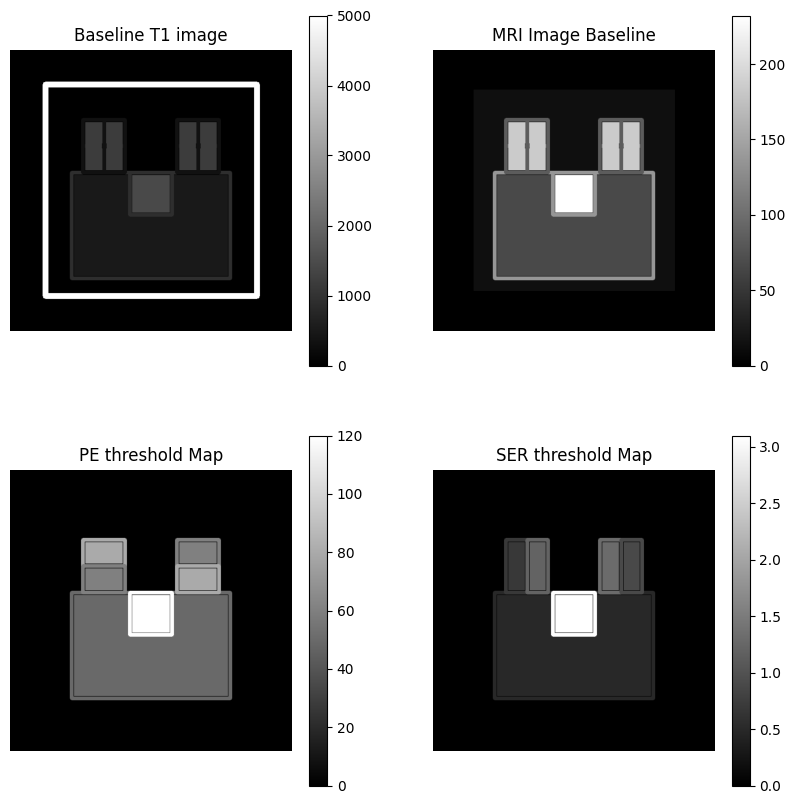

In [24]:
# show the baseline T1 and corresponding signal:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10.0, 10.0))
axr = ax.ravel()

im = [axr[0].imshow(baseline_images['T1'], cmap='gray')]
im.append(axr[1].imshow(baseline_images['St'], cmap='gray'))
im.append(axr[2].imshow(PEmap, cmap='gray'))
im.append(axr[3].imshow(SERmap, cmap='gray'))

axr[0].set_title(r'Baseline T1 image')
axr[0].axis('off')
axr[1].set_title(r'MRI Image Baseline')
axr[1].axis('off')
axr[2].set_title(r'PE threshold Map')
axr[2].axis('off')
axr[3].set_title(r'SER threshold Map')
axr[3].axis('off')
fig.colorbar(im[0], ax=axr[0])
fig.colorbar(im[1], ax=axr[1])
fig.colorbar(im[2], ax=axr[2])
fig.colorbar(im[3], ax=axr[3])

plt.show()


# Create the output as DICOM sequence
To create the output as a dicom sequence, I take one of the dicom headers from the study as a sample and use pydicom's [```codify```](https://pydicom.github.io/pydicom/stable/guides/cli/cli_guide.html#cli-codify) tool to create the code that will define the dicom metadata for each slice (remember that dicom data only process slices, the metadata tells us how to organise it when 3D and 4D).

The code sample ```create_dicom.py``` was created via CLI:

``` bash
user_prompt % pydicom codify sample_DICOM_EilB-preTreatment.dcm > create_dicom.py
```

I created my own UID by requesting it to [Medical Connections](https://www.medicalconnections.co.uk/FreeUID/)



In [26]:
# save the output as nifti analyze (later on will create a dicom)
HOMEPATH = os.getenv('HOME')
DATAPATH = os.path.join(HOMEPATH, 'Data', 'QIBA_DRO', 'samples')
DICOMFLDR = '800'

DICOMPATH = os.path.join(DATAPATH, DICOMFLDR)
os.makedirs(DICOMPATH, exist_ok=True)

today = datetime.datetime.now().strftime('%Y%m%dT%H%M')
# Study details:
studyID = 'ISANDEX_DRO001'
seriesNumber = 800
acquisitionNumber = 1
studyDescription = 'Digital Phantom Construction'
seriesDescription = 'FTV Digital Phantom'
protocolName = 'ISANDEX DRO FTV DCEMRI'
phantomSWversion = ['1.0.0']

# Load my unique UID (created via https://www.medicalconnections.co.uk/FreeUID/)
uid_filename = 'isandexUID.json'
with open(os.path.join(DATAPATH, uid_filename), 'r') as uid_file:
    uid_json = json.loads(uid_file.read())

# Manufacture data: 
uid_code = uid_json['maker']['UID']
uid_machine = uid_json['maker']['machineID']
manufacturer = 'PHILIPS' #uid_json['maker']['manufacturer']
manufacturerModelName = uid_json['maker']['manufacturerModelName']

# phantom details:
dro_birthDate = uid_json['phantom']['dob']
phantomtName = uid_json['phantom']['name']
phantomID = uid_json['phantom']['patientID']
phantomDateOfBirth = uid_json['phantom']['dob']
phantomSex = uid_json['phantom']['sex']
phantomWeight = uid_json['phantom']['weight']
phantomPregnancyStatus = uid_json['phantom']['pregnancyStatus']
phantonIDRemoved = uid_json['phantom']['patientIdentityRemoved']

# Default study details:
requestedProcedureDescription = uid_json['default']['requestedProcedureDescription']

# Create the user defined dictionary to update the corresponding fields in the dicom header:
dicom_user_metadata = {'file_metadata': FileMetaDataset(),
                       'dataset_metadata': Dataset(),
}
dicom_user_metadata['file_metadata'].MediaStorageSOPInstanceUID = '.'.join([uid_code, uid_machine])
dicom_user_metadata['dataset_metadata'].SOPInstanceUID = '.'.join([uid_code, uid_machine])
dicom_user_metadata['dataset_metadata'].InstanceCreatorUID = uid_code

# last two numbers of StudyInstanceUID are randomly generated and then incremented in 1 for each slice and timepoint:
uid_study_instance_UID = np.random.randint(100,1000, size=2)

dicom_user_metadata['dataset_metadata'].StudyInstanceUID = '.'.join([uid_code, uid_machine,'.'.join(uid_study_instance_UID.astype(str))])
dicom_user_metadata['dataset_metadata'].SeriesInstanceUID = '.'.join([uid_code, uid_machine,'.'.join((uid_study_instance_UID + [0, 1]).astype(str))])
dicom_user_metadata['dataset_metadata'].FrameOfReferenceUID = '.'.join([uid_code, uid_machine,'.'.join((uid_study_instance_UID + [0, 2]).astype(str))])
dicom_user_metadata['dataset_metadata'].StudyID = studyID
dicom_user_metadata['dataset_metadata'].SeriesNumber = seriesNumber
dicom_user_metadata['dataset_metadata'].AcquisitionNumber = acquisitionNumber

# Image orientation is centred around the origin:
dicom_user_metadata['dataset_metadata'].ImagePositionPatient = [-0.5*imdim*imres for imdim, imres in zip(image_dim, image_res)]

# Create dataset metadata:
InstanceCreationDateTime = datetime.datetime.now()
InstanceCreationDate = InstanceCreationDateTime.strftime('%Y%m%d')
InstanceCreationTime = InstanceCreationDateTime.strftime('%H%M%S.%f')[:-4] # Thanks, ChatGPT, for the [:-4] tip!!
phantomDOB = datetime.datetime.strptime(phantomDateOfBirth,"%Y/%m/%d")

DRO_Age = InstanceCreationDateTime.year - phantomDOB.year 
if (InstanceCreationDateTime.month, InstanceCreationDateTime.day) < (phantomDOB.month, phantomDOB.day):
    DRO_Age -= 1

dicom_user_metadata['dataset_metadata'].InstanceCreationDate = InstanceCreationDate
dicom_user_metadata['dataset_metadata'].StudyDate = InstanceCreationDate
dicom_user_metadata['dataset_metadata'].SeriesDate = InstanceCreationDate
dicom_user_metadata['dataset_metadata'].AcquisitionDate = InstanceCreationDate
dicom_user_metadata['dataset_metadata'].ContentDate = InstanceCreationDate

dicom_user_metadata['dataset_metadata'].StudyTime = InstanceCreationTime
dicom_user_metadata['dataset_metadata'].SeriesTime = InstanceCreationTime

dicom_user_metadata['dataset_metadata'].Manufacturer = manufacturer
dicom_user_metadata['dataset_metadata'].StudyDescription = studyDescription
dicom_user_metadata['dataset_metadata'].SeriesDescription = seriesDescription
dicom_user_metadata['dataset_metadata'].ManufacturerModelName = manufacturerModelName

dicom_user_metadata['dataset_metadata'].PatientName = phantomtName
dicom_user_metadata['dataset_metadata'].PatientID = phantomID
dicom_user_metadata['dataset_metadata'].PatientBirthDate = phantomDOB
dicom_user_metadata['dataset_metadata'].PatientSex = phantomSex
dicom_user_metadata['dataset_metadata'].PatientAge = f'{DRO_Age:03.0f}Y'
dicom_user_metadata['dataset_metadata'].PatientWeight = phantomWeight
dicom_user_metadata['dataset_metadata'].PregnancyStatus = phantomPregnancyStatus
dicom_user_metadata['dataset_metadata'].PatientIdentityRemoved = phantonIDRemoved

dicom_user_metadata['dataset_metadata'].SliceThickness = image_res[-1]* image_pars['pSL'] # '3.0' Overlap 1/pSL slice width (see SpacingBetween)
dicom_user_metadata['dataset_metadata'].RepetitionTime = image_pars['TR']
dicom_user_metadata['dataset_metadata'].EchoTime = image_pars['TE']
dicom_user_metadata['dataset_metadata'].SpacingBetweenSlices = image_res[-1] # '1.5'
# dicom_user_metadata['dataset_metadata'].NumberOfPhaseEncodingSteps = '359'
# dicom_user_metadata['dataset_metadata'].ReconstructionDiameter = '359.0'
# dicom_user_metadata['dataset_metadata'].AcquisitionMatrix = [0, 359, 359, 0]
dicom_user_metadata['dataset_metadata'].EchoTrainLength = image_pars['ETL']
dicom_user_metadata['dataset_metadata'].PercentSampling = image_pars['pPE']
dicom_user_metadata['dataset_metadata'].PercentPhaseFieldOfView = image_pars['pFOV']
# dicom_user_metadata['dataset_metadata'].PixelBandwidth = '433.0'
# dicom_user_metadata['dataset_metadata'].ReceiveCoilName = 'SENSE_BREAST_7M_'
# dicom_user_metadata['dataset_metadata'].DeviceSerialNumber = '0'


dicom_user_metadata['dataset_metadata'].SoftwareVersions = phantomSWversion # ['1.0.0']
dicom_user_metadata['dataset_metadata'].ProtocolName = protocolName
# dicom_user_metadata['dataset_metadata'].TriggerTime = '0.0'
# dicom_user_metadata['dataset_metadata'].LowRRValue = '0'
# dicom_user_metadata['dataset_metadata'].HighRRValue = '0'
# dicom_user_metadata['dataset_metadata'].IntervalsAcquired = '0'
# dicom_user_metadata['dataset_metadata'].IntervalsRejected = '0'
# dicom_user_metadata['dataset_metadata'].HeartRate = '0'
dicom_user_metadata['dataset_metadata'].InPlanePhaseEncodingDirection = 'ROW'
dicom_user_metadata['dataset_metadata'].FlipAngle = image_pars['FA'] # '10.0'
dicom_user_metadata['dataset_metadata'].SAR = 0.22448302805423 # Sample values from another study
dicom_user_metadata['dataset_metadata'].dBdt = 56.1810722351074# Sample values from another study
dicom_user_metadata['dataset_metadata'].B1rms = 1.089730978012085 # Sample values from another study
dicom_user_metadata['dataset_metadata'].PatientPosition = 'FFP' # Sample values from another study

dicom_user_metadata['dataset_metadata'].AcquisitionDuration = Tacq 

# Image Parameters
dicom_user_metadata['dataset_metadata'].SamplesPerPixel = 1
dicom_user_metadata['dataset_metadata'].PhotometricInterpretation = 'MONOCHROME2'
dicom_user_metadata['dataset_metadata'].Rows = image_dim[1] # 528
dicom_user_metadata['dataset_metadata'].Columns = image_dim[1] # 528
dicom_user_metadata['dataset_metadata'].PixelSpacing = image_res[:-1] # [0.67961162328720, 0.67961162328720]
dicom_user_metadata['dataset_metadata'].BitsAllocated = image_pars['nBits']
dicom_user_metadata['dataset_metadata'].BitsStored = image_pars['nBits']
dicom_user_metadata['dataset_metadata'].HighBit = image_pars['nBits']-1
dicom_user_metadata['dataset_metadata'].PixelRepresentation = 0

# Just keep things simple, so set the scaling to unchange the pixels (i.e. normalise=False)
normalise = False
rawImg = StFull.copy()
nbits = image_pars['nBits']
uintScale = 2**nbits - 1
minMax = [np.min(StFull), np.max(StFull)]
DeltaImg = np.diff(minMax)[0]
if normalise:
    # normalise the image to [0; 1] and then to [0; 2^nbit - 1]
    rawImg -= minMax[0] 
    rawImg /= DeltaImg
    rawImg *= uintScale
    RescaleSlope = DeltaImg / uintScale
    RescaleIntercept = minMax[0]
else:
    RescaleSlope = 1.0 
    RescaleIntercept = 0.0 
    
dicom_user_metadata['dataset_metadata'].RescaleIntercept = RescaleIntercept
dicom_user_metadata['dataset_metadata'].RescaleSlope = RescaleSlope
dicom_user_metadata['dataset_metadata'].RescaleType = 'normalized'

dicom_user_metadata['dataset_metadata'].RequestedProcedureDescription = requestedProcedureDescription
dicom_user_metadata['dataset_metadata'].RequestedContrastAgent = ''
dicom_user_metadata['dataset_metadata'].StudyComments = ''
dicom_user_metadata['dataset_metadata'].SpecialNeeds = ''
dicom_user_metadata['dataset_metadata'].PatientState = ''
dicom_user_metadata['dataset_metadata'].ScheduledPerformingPhysicianName = ''
dicom_user_metadata['dataset_metadata'].PerformedStationAETitle = 'MRSIM'
dicom_user_metadata['dataset_metadata'].PerformedStationName = ''
dicom_user_metadata['dataset_metadata'].PerformedLocation = ''

# End dataset metadata:
InstanceEndProcedureDateTime = datetime.datetime.now()
InstanceEndProcedureDate = InstanceEndProcedureDateTime.strftime('%Y%m%d')
InstanceEndProcedureTime = InstanceEndProcedureDateTime.strftime('%H%M%S.%f')[:-4] # Thanks, ChatGPT, for the [:-4] tip!!

dicom_user_metadata['dataset_metadata'].PerformedProcedureStepEndDate = InstanceEndProcedureDate # '20230621'
dicom_user_metadata['dataset_metadata'].PerformedProcedureStepEndTime = InstanceEndProcedureTime # '101805'
dicom_user_metadata['dataset_metadata'].PerformedProcedureStepStatus = ''
dicom_user_metadata['dataset_metadata'].PerformedProcedureTypeDescription = ''

# Ensuring the SOPInstanceUID attributes changes for each image was key to make it readable as a sequence in Slicer3D
instanceUID = uid_study_instance_UID + [0, 3]
for tind, ti in enumerate(time_points):
    CurrrentTime = datetime.datetime.now()

    AcquisitionDateTime = InstanceCreationDateTime + datetime.timedelta(0, tind*Tacq)

    AcquisitionDate = AcquisitionDateTime.strftime('%Y%m%d')
    AcquisitionTime = AcquisitionDateTime.strftime('%H%M%S.%f')[:-4]
    dicom_user_metadata['dataset_metadata'].TriggerTime = f'{tind*Tacq*1000:.2f}'
    for slice_nro in range(image_dim[-1]):
        nacq = slice_nro + tind * image_dim[-1]
        zpos =  ( slice_nro - ( (image_dim[-1] - 1.0) / 2.0 ) ) * image_res[-1]
        dicom_user_metadata['dataset_metadata'].InstanceCreationTime = (CurrrentTime + datetime.timedelta(0, tind*Tacq)).strftime('%H%M%S.%f')[:-4]# f'{AcquisitionTime}' # InstanceCreationTime
        
        dicom_user_metadata['dataset_metadata'].AcquisitionTime = AcquisitionTime # '105057.46' # This changes for every timepoint
        dicom_user_metadata['dataset_metadata'].ContentTime = AcquisitionTime    # '105057.46' # This is the same as the AcquisitionTime, I think...

        dicom_user_metadata['dataset_metadata'].InstanceNumber = nacq+1
        # Ensuring the SOPInstanceUID attributes changes for each image was key to make it readable as a sequence in Slicer3D
        dicom_user_metadata['dataset_metadata'].SOPInstanceUID = '.'.join([uid_code, uid_machine, '.'.join(instanceUID.astype(str))])
        instanceUID += [1, 1]

        dicom_user_metadata['dataset_metadata'].ImagePositionPatient[-1] = zpos
        dicom_user_metadata['dataset_metadata'].ImageOrientationPatient = [1, 0, 0, 0, 1, 0]
        dicom_user_metadata['dataset_metadata'].Laterality = ''
        dicom_user_metadata['dataset_metadata'].TemporalPositionIdentifier = f'{tind+1}'
        dicom_user_metadata['dataset_metadata'].NumberOfTemporalPositions = f'{len(time_points)}'
        dicom_user_metadata['dataset_metadata'].PositionReferenceIndicator = ''
        dicom_user_metadata['dataset_metadata'].SliceLocation = f'{zpos}' # '0.0' # '-57.847473144531'
        
        img16 = rawImg[:,:,slice_nro,tind]
        img16 = np.uint16(img16)
        dicom_user_metadata['dataset_metadata'].PixelData = img16.tobytes()

        minMax = [np.min(img16), np.max(img16)]
        DeltaImg = np.diff(minMax)[0]

        # This is just for display purposes, it sets which values are going to be set to 0 in the display
        dicom_user_metadata['dataset_metadata'].WindowCenter = np.mean(minMax) # '1214.0'
        dicom_user_metadata['dataset_metadata'].WindowWidth = DeltaImg # '2110.0'

        path_to_save = os.path.join(DICOMPATH, f'sample_dicom_test_{(nacq+1):04d}.dcm')
        dicom_object = create_dicom_header(dicom_user_metadata)

        dicom_object.save_as(path_to_save, write_like_original=False)


# Appendices

## Linearisation of the SPGR equation
By considering $T_E << T_R$, $E_1(T_1, T_R)$ as just $E_1$, and repeating the acquisition for multiples flip angles $\alpha_i$ while keeping everything else constant, specially $T_R$ and $T_E$, the equation [] becomes:
\begin{equation}
S(\alpha_i) = S_i = M_0\sin\alpha_i\frac{1 - E_1}{1 - (\cos\alpha_i)E_1}
\end{equation}
multiplying by $(1 - (\cos\alpha_i)E_1)$:
\begin{equation}
S_i - S_i\cos\alpha_iE_1 = M_0\sin\alpha_i - M_0\sin\alpha_i E_1
\end{equation}
dividing by $\sin\alpha_i$ and reorganising the terms:
\begin{equation}
\frac{S_i}{\sin\alpha_i} - \frac{S_iE_1}{\tan\alpha_i} = M_0 - M_0E_1
\end{equation}
and isolating the signal intensity as a function of $E_1$, we get:
\begin{equation}
\frac{S_i}{\sin\alpha_i} = E_1\frac{S_i}{\tan\alpha_i} + M_0(1 - E_1)
\end{equation}


## Relaxitivy of contrast agents at 1.5T
The following table has been taken from https://s.mriquestions.com/what-is-relaxivity.html and is based on [Rohrer et al. Invest. Radiol 40:715-724; 2005](https://journals.lww.com/investigativeradiology/abstract/2005/11000/comparison_of_magnetic_properties_of_mri_contrast.5.aspx)

Relaxivitiy of plasma blood at $37^{o}$ and 1.5T:

| Brand Name  | $r_1\quad[L\ mmol^{-1} s^{-1}]$ |
| ------------|  :---------------------------:  |
| Magnevist®  | 4.1  |
| MultiHance® | 6.3  |
| Omniscan ™  | 4.3  |
| Dotarem®    | 3.6  |
| ProHance®   | 4.1  |
| Gadavist®   | 5.2  |
| Eovist®     | 6.9  |
| Vueway™     | 12.8 |


## $T_1$ of tissues at 1.5T
The following table has been taken from https://mri-q.com/why-is-t1--t2.html, for breast (fat and glandular tissues), I've used the average reported by [Rakow-Penner et al. JMRI 23(1): 87-91; 2005](https://onlinelibrary.wiley.com/doi/full/10.1002/jmri.20469) and for malingant breast tissue, I've followed the book ["Breast MRI: Fundamentals and Technical Aspects", R.E. Hendriks, 2008](https://link.springer.com/book/10.1007/978-0-387-73507-8), its paper conference ["Breast MRI: Using Physics to Maximize Its Sensitivity and
Specificity to Breast Cancer"](https://www.aapm.org/meetings/04AM/pdf/14-2345-77728.pdf), which cited [Mechant TE et al. Acta Radiologica 34(4):356-361; 1993](https://journals.sagepub.com/doi/10.1177/028418519303400409). Blood relaxation times were taken from [M. Barth and E. Moser. Cell Mol Biol 43(5): 783-791; 1997](https://pubmed.ncbi.nlm.nih.gov/9298600/)

Average $T_1$ values of some tissues at 1.5T

|    Tissue   | $T_1$[ms] | $T_2$[ms] |
| ----------- | :-------: | :-------: |
| Water/CSF   | 4000      | 2000      |
| Gray matter | 900       | 90        | 
| Muscle      | 900       | 50        | 
| Liver       | 500       | 40        | 
| Fat         | 250       | 70        | 
| Tendon      | 400       | 5         | 
| Proteins    | 250       | 0.1- 1.0  | 
| Ice         | 5000      | 0.001     | 
| Fat Tissue (Breast)       | 334   | 53 |
| Glandular Tissue (Breast) | 1201  | 58 |
| Malignant Tissue (Breast) | 876   | 75 |
| Blood (Arterial @23C) | 1434   | 254 |

